In [1]:
import Pkg
Pkg.activate(pwd())

using HTTP
using Gumbo
using AbstractTrees
using Dates
using DataFrames
using MySQL

using VegaLite
using DataVoyager
using Interact

using TextAnalysis
using JSON

using DotEnv

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1174089205638473775\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10909338116274042034\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1174089205638473775\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
DotEnv.config()
opts = Dict(MySQL.API.MYSQL_ENABLE_CLEARTEXT_PLUGIN => 1)
user = ENV["mysql_user"]
pass = ENV["mysql_password"]
conn = MySQL.connect("pdspracticemydbcit.services.brown.edu", user,pass, db = "ccvpubs", opts=opts)

MySQL Connection
------------
Host: pdspracticemydbcit.services.brown.edu
Port: 3306
User: ccvpubs_api
DB:   ccvpubs


In [3]:
data = MySQL.query(conn, """SELECT * FROM pubsNew;""", DataFrame)
small_data = DataFrame( year = parse.(Int, data[!, :year]))

┌ Warning: `MySQL.query(conn, sql, DataFrame)` is deprecated; use `MySQL.query(conn, sql) |> DataFrame(args...)` instead
│   caller = ip:0x0
└ @ Core :-1


,year
,Int64
1,2017
2,2017
3,2017
4,2017
5,2018
6,2018
7,2017
8,2017
9,2017


In [4]:
small_data |> Voyager();

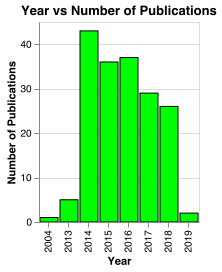

In [6]:

spec = vl"""{
  "title": "Year vs Number of Publications",
  "data": {
    "name": "source"
  },
    "selection": {
    "highlight": {"type": "single", "empty": "none", "on": "mouseover"},
    "select": {"type": "multi"}
  },
  "mark": {
    "type": "bar",
    "fill": "#00FF00",
    "stroke": "black",
    "cursor": "pointer"
  },
  "encoding": {
    "x": {
        "title": "Year",
      "field": "year",
      "type": "nominal"
    },
    "y": {
      "aggregate": "count",
      "field": "*",
      "type": "quantitative",
        "title": "Number of Publications"
    },
     "fillOpacity": {
      "condition": {"selection": "select", "value": 1},
      "value": 0.3
    }
 
  },
  "config": {
    "overlay": {
      "line": true
    },
    "scale": {
      "useUnaggregatedDomain": true
    }
  }
}"""(small_data)